In [1]:
from netCDF4 import Dataset
from glob import glob
import os, sys

is_py = os.path.basename(sys.argv[0]) == 'vert-contour.ju.py'
RUN_ID = int(sys.argv[1]) if is_py and len(sys.argv) > 1 else 45

root_dir = '/home/guc/'
data_dir = f'runs/{RUN_ID:03}*/'
root_data_dir = glob(root_dir + data_dir)[0]

image_dir = root_data_dir + 'results/images/'
if len(glob(image_dir)) == 0:
    os.mkdir(image_dir)

dataset = Dataset(glob(root_data_dir + 'wrfout*')[0])

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from wrf import getvar, to_np, extract_times, ALL_TIMES, vertcross, CoordPair

plt.rcParams["font.family"] = "DejaVu Sans Mono"

# === EDIT COORDS HERE ===
# START = (33, 140) # Y, X
# END = (37, 140) # Y, X

START = (35, 138) # Y, X
END = (35, 142) # Y, X

start_point = CoordPair(lat = START[0], lon = START[1])
end_point = CoordPair(lat = END[0], lon = END[1])
vert_levels = np.linspace(0, 2000, 200)

z_data = getvar(dataset, "z", timeidx=0)
var_data_template = getvar(dataset, "wa", timeidx=0)

def get_cross_var(var, time_idx):
    return vertcross(
        var,
        z_data,
        levels=vert_levels,
        wrfin=dataset,
        timeidx=time_idx,
        start_point=start_point,
        end_point=end_point,
        latlon=True,
        meta=True
    )

var_template = get_cross_var(var_data_template, 0)

In [3]:
times = extract_times(dataset, timeidx=ALL_TIMES)
threshold_datetime = np.datetime64('2025-06-18')
u_cross_means = np.zeros(var_template.shape)
v_cross_means = np.zeros(var_template.shape)
w_cross_means = np.zeros(var_template.shape)
var_cross_means = np.zeros(var_template.shape)

for time_idx, datetime in enumerate(times):
    if (datetime < threshold_datetime): continue

    print(f'Processing time {datetime}', end='\r')
    u_data = getvar(dataset, "ua", timeidx=time_idx)
    v_data = getvar(dataset, "va", timeidx=time_idx)
    w_data = getvar(dataset, "wa", timeidx=time_idx)
    var_data = getvar(dataset, "QRAIN", timeidx=time_idx)

    u_cross = get_cross_var(u_data, time_idx)
    v_cross = get_cross_var(v_data, time_idx)
    w_cross = get_cross_var(w_data, time_idx)
    var_cross = get_cross_var(var_data, time_idx)

    u_cross_means += np.abs(to_np(u_cross))
    v_cross_means += np.abs(to_np(v_cross))
    w_cross_means += np.abs(to_np(w_cross))
    var_cross_means += np.abs(to_np(var_cross))

times_len = len(times[times >= threshold_datetime])
u_cross_means /= times_len
v_cross_means /= times_len
w_cross_means /= times_len
var_cross_means /= times_len

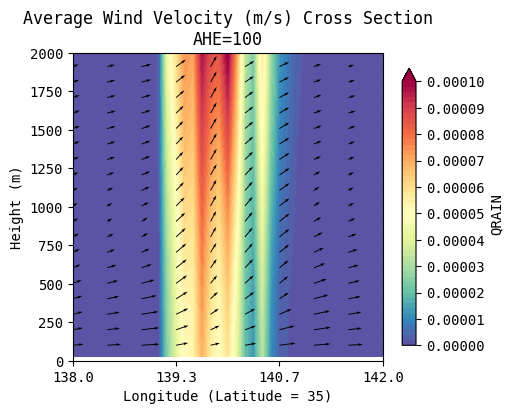

In [6]:
plt.figure(figsize=(5, 4)) # width, height
ax = plt.axes()

vert_vals = to_np(var_template.coords["vertical"])
coord_pairs = to_np(var_template.coords['xy_loc'])
coord_pair_labels = [f'{float(pair.latlon_str().split(',')[1]):.1f}' for pair in to_np(coord_pairs)]
ax.set_xticks(np.arange(coord_pairs.shape[0])[::12])

mask_x = slice(None, None, 4)
mask_y = slice(None, None, 10)

plt.ylabel('Height (m)')
plt.xlabel('Longitude (Latitude = 35)')

plot_lim = np.linspace(0, 0.0001, 51)
plt.contourf(coord_pair_labels, vert_levels, var_cross_means, plot_lim, cmap="Spectral_r", extend="max")
cbar = plt.colorbar(shrink=.9, ticks=plot_lim[::5])
cbar.ax.set_ylabel('QRAIN')

ax.quiver(
    coord_pair_labels[mask_x],
    to_np(vert_levels)[mask_y],
    to_np(u_cross_means)[mask_y, mask_x],
    to_np(w_cross_means * 10)[mask_y, mask_x],
    scale=40,
    width=0.003
)

plt.title(f"Average Wind Velocity (m/s) Cross Section\nAHE=100")

plt.savefig('/home/guc/results/cross-section/wind-qrain-lon.png')